In [1]:
import sys
import os
import neo
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import seaborn as sns
import elephant as el
import quantities as pq
sns.set(style='ticks', palette='bright', context='talk')
sns.set_color_codes(palette='muted')

In [2]:
neo.__version__ # to 0.5b

'0.5.1'

## Load data with neo IO

In [3]:
filename = os.path.expanduser('~') + '/Sciebo/Data/WaveScalES/IDIBAPS/161101_rec07_Spontaneous_RH.smr'
neo_obj = neo.io.spike2io.Spike2IO(filename)

In [4]:
segment = neo_obj.read_segment()

## Annotate the analogsignals with metadata

In [5]:
electrode_location = {'Visual Cortex' : [18,19,20,22,23,24,25,27,28,29,30,31,32],
                      'Retrospenial Cortex' : [13,17,21,26],
                      'Parietal Association Cortex' : [14,15,16],
                      'Somatosensory Cortex' : [4,5,7,8,10,11,12],
                      'Motor Cortex' : [1,2,3,6,9]
                     }

electrode_color = {'Visual Cortex' : '#0C6BB1',
                   'Retrospenial Cortex' : '#422F58',
                   'Parietal Association Cortex' : '#01B24E',
                   'Somatosensory Cortex' : '#F92600',
                   'Motor Cortex' : '#EF6700'
                     }

for asig in segment.analogsignals:
    for element in electrode_location:
        if asig.annotations['physical_channel_index']+1 in electrode_location[element]:
            asig.annotations['cortical_location'] = element
            
# ToDo: Annotate with x and y position

## Plot signal traces

In [6]:
asig = segment.analogsignals[0] 
num_sampling_points = (asig.t_stop.rescale('s') - asig.t_start.rescale('s')) \
                    * asig.sampling_rate.rescale('1/s')
sampling_times = np.linspace(asig.t_start, asig.t_stop, num_sampling_points)

/home/rgutzen/anaconda3/envs/wavescale/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'quantities.quantity.Quantity'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


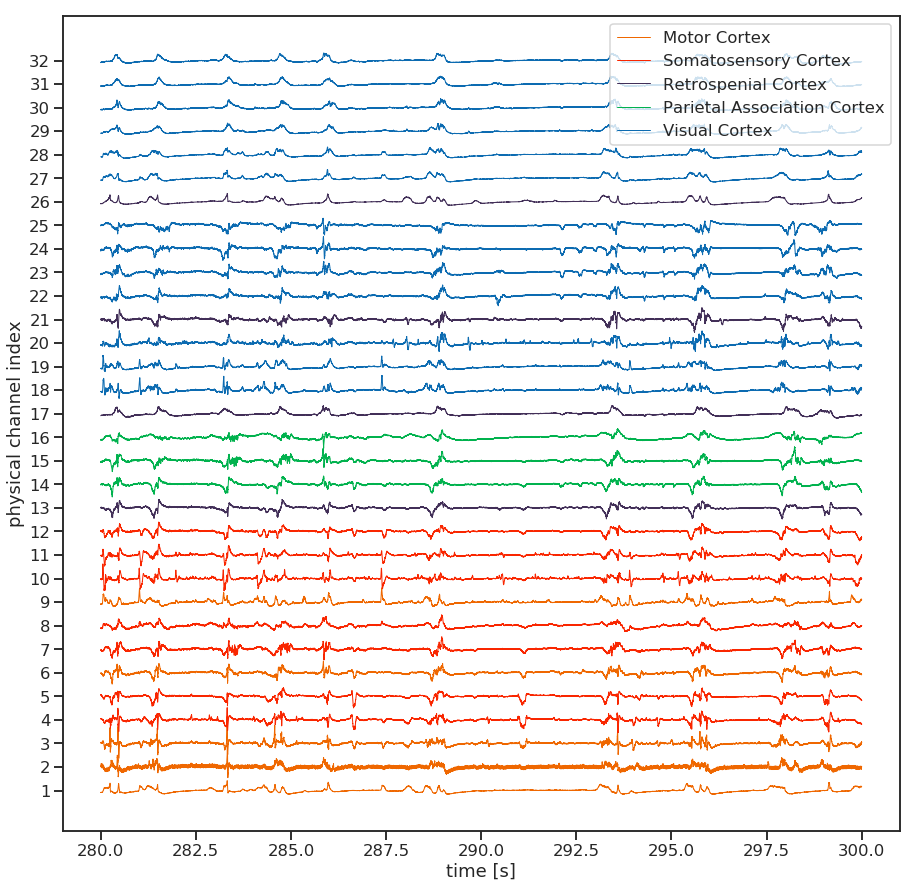

In [7]:
time_window = (280,300)  # in seconds [0,304]

fig, ax = plt.subplots(figsize=(15,15))
idx = [int(time_in_s * asig.sampling_rate.rescale('1/s').magnitude) for time_in_s in time_window]
scaling = 12
handles = {}
sorted_asigs = sorted(segment.analogsignals, key=lambda x: int(x.annotations['physical_channel_index']))
for asig_count, asig in enumerate(sorted_asigs):
    handle,  = ax.plot(sampling_times[idx[0]:idx[1]], 
               sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]) + asig_count*scaling,
               linewidth=1, color=electrode_color[asig.annotations['cortical_location']],
               label=asig.annotations['cortical_location'])
    handles[asig.annotations['cortical_location']] = handle
    
ax.set_yticks(np.arange(len(segment.analogsignals))*scaling)
ax.set_yticklabels([asig.annotations['physical_channel_index']+1 for asig in sorted_asigs])
ax.set_ylabel('physical channel index')
ax.set_xlabel('time [s]')
plt.legend([handle for handle in handles.values()], 
           [location for location in handles.keys()], loc=1)

## Filter signal (200 - 1500 Hz)

In [8]:
MUAFreqBand = (200, 1500)  # Hz
analogsignals_filtered = [el.signal_processing.butter(asig, highpass_freq=MUAFreqBand[0]*pq.Hz, lowpass_freq=MUAFreqBand[1]*pq.Hz, 
                         order=4, filter_function='filtfilt', fs=1.0, axis=-1) for asig in segment.analogsignals]

## Plot power spectrum

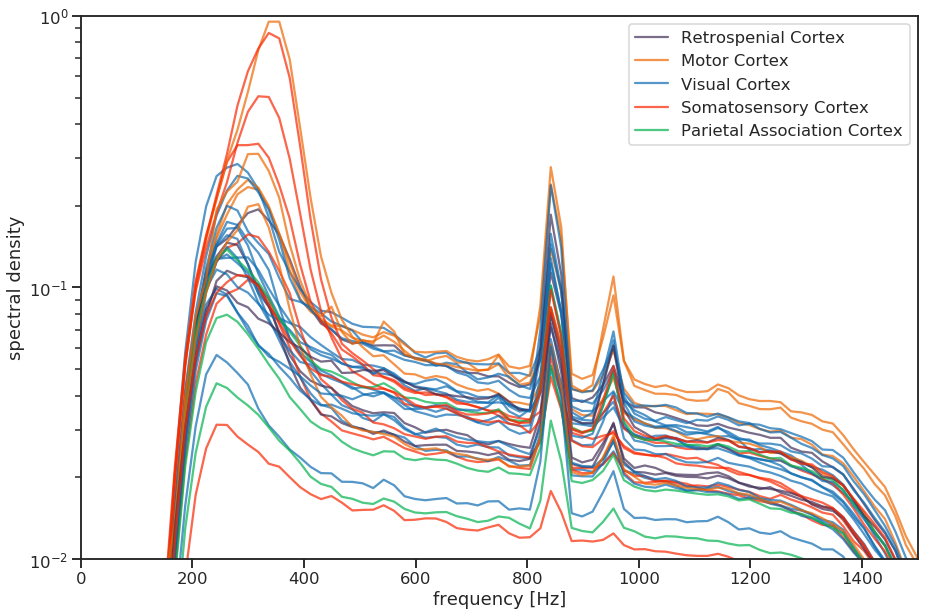

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
handles = {}
for asig_count, asig in enumerate(analogsignals_filtered):
    (p1, f1) = psd(np.squeeze(asig.magnitude), NFFT=265, noverlap=50, 
                   Fs=asig.sampling_rate.rescale('Hz'))
    handle, = ax.semilogy(f1, p1, alpha=0.7, 
                          color=electrode_color[asig.annotations['cortical_location']])
    handles[asig.annotations['cortical_location']] = handle
ax.set_xlim((0,1500))
ax.set_ylim((10**(-2),10**(0)))
ax.set_ylabel('spectral density')
ax.set_xlabel('frequency [Hz]')
plt.legend([handle for handle in handles.values()], 
           [location for location in handles.keys()], loc=1)

## MUA estimation (for one channel)

In [16]:
channel_idx = 12
asig = analogsignals_filtered[channel_idx]
# asig = segment.analogsignals[channel_idx]


fs = asig.sampling_rate.rescale('1/s').magnitude
FFTWindowSize = int(round(fs / MUAFreqBand[0]))
sample_num = int(np.floor(len(asig)/FFTWindowSize))
print('FFTWindowSize', FFTWindowSize)
print('sample_num', sample_num)

def detrending(asig, order=2):
    X = asig.as_array()
    window_size = len(asig)
    if order > 0:
        X = X - np.mean(X, axis=0)
    if order > 1:
        factor = [1,1/2.,1/6.]
        for i in np.arange(order-1)+1:
            detrend = np.linspace(-window_size/2., window_size/2., window_size)**i \
                      * np.mean(np.diff(X, n=i, axis=0)) * factor[i-1]
            X = X - detrend
    return X

MUA = np.zeros(sample_num)

# calculating mean spectral power in each window
for i in range(sample_num):
    local_asig = asig[i*FFTWindowSize:(i+1)*FFTWindowSize]
    local_asig = detrending(local_asig, 1)
    (f,p) = el.spectral.welch_psd(np.squeeze(local_asig), num_seg=10, overlap=0.7, 
                          window='hanning', nfft=None, fs=fs,
                          detrend='constant', return_onesided=True, 
                          scaling='density', axis=-1)
    low_idx = np.where(MUAFreqBand[0] <= f)[0][0]
    high_idx = np.where(MUAFreqBand[1] <= f)[0][0]
    MUA[i] = np.mean(p[low_idx:high_idx])

# ToDo: Normalization with basline power?

FFTWindowSize 25
sample_num 60337


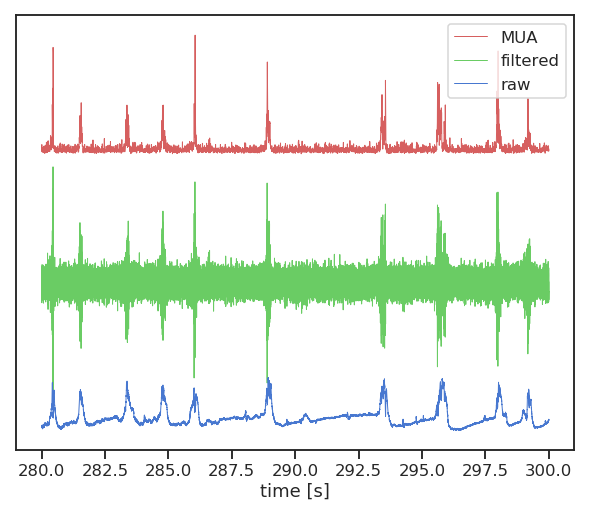

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

asig = segment.analogsignals[channel_idx]
asig_filtered = analogsignals_filtered[channel_idx]
idx = [int(time_in_s * asig.sampling_rate.rescale('1/s').magnitude) 
       for time_in_s in time_window]
MUA_idx = [int(i/FFTWindowSize) for i in idx]

ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
        sc.stats.zscore(MUA)[MUA_idx[0]:MUA_idx[1]] + 30, 
        color='r', label='MUA', lw=1)
ax.plot(asig_filtered.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig_filtered.magnitude[idx[0]:idx[1]]) + 15, 
        color='g', label='filtered', lw=1)
ax.plot(asig.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]), 
        color='b', label='raw', lw=1)
ax.set_xlabel('time [s]')
ax.set_yticks([])
plt.legend()

## Distribution of estimated signal amplitudes (log MUA)

Text(1.7929036843752082, -0.05149807485455158, 'UD threshold (3$\\sigma$)')

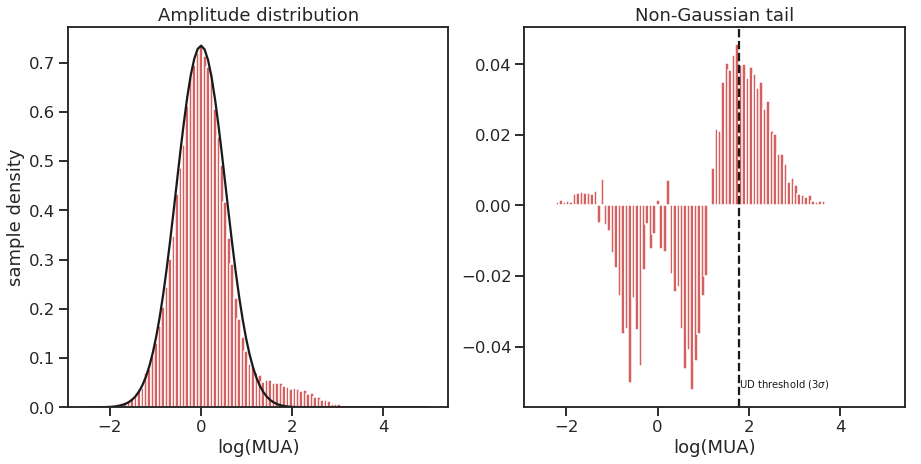

In [18]:
# signal amplitude distribution
hist, edges = np.histogram(np.log(MUA), bins=100, density=True)
xvalues = edges[:-1]+np.diff(edges)[0]/2.

# Gaussian fit
gaussian = lambda x, m, s: 1./(s*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-m)/s)**2)
(m0, s0), _ = sc.optimize.curve_fit(gaussian, xvalues, hist, p0=(-4,1))

# UD threshold
UDth = 3*s0

# shifting to 0
xvalues -= m0

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].bar(xvalues, hist, width=1.1*np.diff(xvalues)[0], color='r')
ax[0].plot(xvalues, [gaussian(x, 0, s0) for x in xvalues], c='k')
ax[0].set_xlabel('log(MUA)')
ax[0].set_ylabel('sample density')
ax[0].set_title('Amplitude distribution')

ax[1].bar(xvalues, [hist[i]-gaussian(x,0,s0) for (i,x) in enumerate(xvalues)],
          width=1.1*np.diff(xvalues)[0], color='r')
ax[1].set_xlabel('log(MUA)')
ax[1].set_title('Non-Gaussian tail')
ax[1].axvline(1.1*UDth, color='k', ls='--'), 
ax[1].text(1.1*UDth, 0.9*ax[1].get_ylim()[0], 
           r'UD threshold ({}$\sigma$)'.format(int(round(UDth/s0))), color='k')

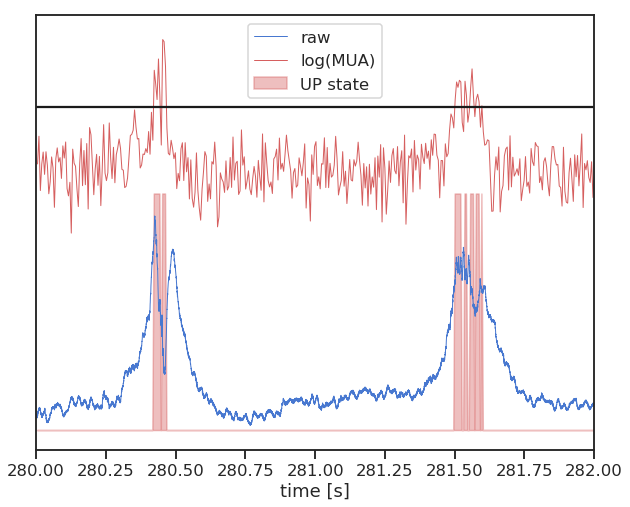

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

up = np.max(sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]))
down = np.min(sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]))

UD_state = [up if np.log(mua)-m0 > UDth else down for mua in MUA[MUA_idx[0]:MUA_idx[1]]]

ax.plot(asig.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]), 
        color='b', label='raw', lw=1)

# ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
#         UD_state, color='r', lw=1, label='UD state')          

ax.fill_between(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
                [down for _ in UD_state], UD_state, 
                color='r', alpha=0.4, label='UP state')  

ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
        np.log(MUA[MUA_idx[0]:MUA_idx[1]])-m0 + 5, 
        color='r', label='log(MUA)', lw=1)

ax.axhline(UDth+5, color='k')

ax.set_xlabel('time [s]')
ax.set_yticks([])
plt.legend()
ax.set_xlim((280,282));

In [14]:
# increase window size? smooth log(MUA)? no prior filtering?

In [15]:
# Next steps: detect wave fronts and visualize moving waves in space